<h1 style="text-align: center; font-size: 50px;">Multimodal RAG Chatbot with Langchain and ML Flow Evaluation</h1>

Retrieval-Augmented Generation (RAG) is an architectural approach that can enhance the effectiveness of large language model (LLM) applications using customized data. In this example, we use LangChain, an orchestrator for language pipelines, to build an assistant capable of loading information from a web page and use it for answering user questions. We'll also use the DeepEval platform to evaluate, observe and protect the LLM responses.

# Notebook Overview
- Imports
- Configurations
- Verify Assets
- Data Loading
- Creation of Chunks
- Retrieval
- Model Setup
- Chain Creation
- Model Service 

# Imports

By using our Local GenAI workspace image, many of the necessary libraries to work with RAG already come pre-installed - in our case, we just need to add the connector to work with PDF documents

In [2]:
%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
# === Standard Library Imports ===
from typing import List, Dict, Any
from datetime import datetime
import warnings
from pathlib import Path
import os
import sys
import logging
import pandas as pd
import json
from copy import deepcopy
from tqdm import tqdm
from collections import defaultdict

# === MLflow integration ===
import mlflow

# Define the relative path to the 'core' directory (one level up from current working directory)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
# === Import ChatbotService from project core ===
from core.chatbot_service.chatbot_service import ChatbotService

# === Third-Party Imports ===
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.embeddings import Embeddings
from langchain_core.documents import Document
from langchain_core.runnables import Runnable, RunnablePassthrough, RunnableLambda
from langchain.vectorstores import Chroma
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.document import Document
from langchain.document_loaders import WebBaseLoader, JSONLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings

import promptquality as pq
import torch
from langchain_core.output_parsers import StrOutputParser
import base64, os, mimetypes
from chromadb.config import Settings
from transformers import SiglipProcessor, SiglipModel
from llama_cpp import Llama

# Define the relative path to the 'src' directory (one level up from current working directory)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# === Project-Specific Imports (from src) ===
from src.local_genai_judge import LocalGenAIJudge
from src.utils import (
    load_config_and_secrets,
    configure_proxy,
    initialize_llm,
    configure_hf_cache,
    mlflow_evaluate_setup,
)

2025-07-15 00:31:56.263280: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 00:31:56.395624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752539516.445397    3671 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752539516.459903    3671 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752539516.569432    3671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Configurations

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Create logger
logger = logging.getLogger("multimodal_rag_logger")
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", 
                              datefmt="%Y-%m-%d %H:%M:%S") 

stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.propagate = False

In [6]:
CONFIG_PATH = "../configs/config.yaml"
SECRETS_PATH = "../configs/secrets.yaml"
DATA_PATH = "../data"
IMAGE_DIR = os.path.join(DATA_PATH, "images")  # PNG/JPGs
MM_JSON = os.path.join(DATA_PATH, "wiki_flat_structure.json")

MLFLOW_EXPERIMENT_NAME = "AIStudio-Multimodal-Chatbot-Experiment"
MLFLOW_RUN_NAME = "AIStudio-Multimodal-Chatbot-Run"

LOCAL_MODEL_PATH = "/home/jovyan/datafabric/llama3.1-8b-instruct/Meta-Llama-3.1-8B-Instruct-Q8_0.gguf"
INTERNVL_MODEL_PATH = "/home/jovyan/datafabric/InternVL3-8B-Instruct-Q8_0/InternVL3-8B-Instruct-Q8_0.gguf"
MM_PROJ_PATH = "/home/jovyan/datafabric/mmproj-InternVL3-8B-Instruct-Q8_0/mmproj-InternVL3-8B-Instruct-Q8_0.gguf"

DEMO_FOLDER = "../demo"
MLFLOW_MODEL_NAME = "AIStudio-Multimodal-Chatbot-Model"

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
logger.info('Notebook execution started.')

2025-07-15 00:32:00 - INFO - Notebook execution started.


## Configuration of HuggingFace caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [9]:
# Configure HuggingFace cache
configure_hf_cache()

In [10]:
# Initialize HuggingFace Embeddings
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-large-v2",
    cache_folder="/tmp/hf_cache"
)

2025-07-15 00:32:00,834 - INFO - PyTorch version 2.7.0 available.
2025-07-15 00:32:00,836 - INFO - TensorFlow version 2.19.0 available.
2025-07-15 00:32:00,981 - INFO - Use pytorch device_name: cuda:0
2025-07-15 00:32:00,981 - INFO - Load pretrained SentenceTransformer: intfloat/e5-large-v2


## Configuration and Secrets Loading

In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like Galileo and HuggingFace

In [11]:
config, secrets = load_config_and_secrets(CONFIG_PATH, SECRETS_PATH)

# Verify Assets

In [12]:
def log_asset_status(asset_path: str, asset_name: str, success_message: str, failure_message: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")

log_asset_status(
    asset_path=CONFIG_PATH,
    asset_name="Config",
    success_message="",
    failure_message="Please check if the configs.yaml was propely connfigured in your project on AI Studio."
)

log_asset_status(
    asset_path=SECRETS_PATH,
    asset_name="Secrets",
    success_message="",
    failure_message="Please check if the secrets.yaml was propely connfigured in your project on AI Studio."
)

log_asset_status(
    asset_path=INTERNVL_MODEL_PATH,
    asset_name="Local InternVL-8B model",
    success_message="",
    failure_message="Please create and download the required assets in your project on AI Studio if you want to use local model.")

log_asset_status(
    asset_path=MM_PROJ_PATH,
    asset_name="Vision projector (.gguf)",
    success_message="",
    failure_message="Download mmproj-InternVL3-8B-Instruct-Q8_0.gguf")

log_asset_status(
    asset_path=MM_JSON,
    asset_name="wiki_flat_structure.json",
    success_message="",
    failure_message="Place JSON Wiki Pages in data/")

2025-07-15 00:32:03 - INFO - Config is properly configured. 
2025-07-15 00:32:03 - INFO - Secrets is properly configured. 
2025-07-15 00:32:03 - INFO - Local InternVL-8B model is properly configured. 
2025-07-15 00:32:03 - INFO - Vision projector (.gguf) is properly configured. 
2025-07-15 00:32:03 - INFO - wiki_flat_structure.json is properly configured. 


# Data Loading & Cleaning

We load wiki-pages from `wiki_flat_structure.json`, but:
* remove any image name that  
  – is empty / `None`  
  – contains invalid characters (e.g. the `==image_0==` placeholders)  
  – has an extension not in {png, jpg, jpeg, webp, gif}  
  – points to a file that does **not** exist in `data/images/`
* log every discarded image so we can fix the parser later.

In [13]:
VALID_EXTS = {".png", ".jpg", ".jpeg", ".webp", ".gif"}

MM_JSON   = Path(MM_JSON)
IMAGE_DIR = Path(IMAGE_DIR)

def load_mm_docs_clean(json_path: Path, img_dir: Path) -> List[Document]:
    """
    Load wiki Markdown + image references from *json_path*.
    • Filters out images with bad extensions or missing files.
    • Logs the first 20 broken refs.
    • Returns a list[Document] where metadata = {source, images}
    """
    bad_imgs, docs = [], []

    rows = json.loads(json_path.read_text("utf-8"))
    for row in rows:
        images_ok = []
        for name in row.get("images", []):
            if not name:                                     # empty / placeholder
                bad_imgs.append((row["path"], name, "empty"))
                continue
            ext = Path(name).suffix.lower()
            if ext not in VALID_EXTS:                       # unsupported ext
                bad_imgs.append((row["path"], name, f"ext {ext}"))
                continue
            img_path = img_dir / name
            if not img_path.is_file():                      # missing on disk
                bad_imgs.append((row["path"], name, "missing file"))
                continue
            images_ok.append(name)

        docs.append(
            Document(
                page_content=row["content"],
                metadata={"source": row["path"], "images": images_ok},
            )
        )

    # ---- summary logging ----------------------------------------------------
    if bad_imgs:
        logger.warning("⚠️ %d broken image refs filtered out", len(bad_imgs))
        for src, name, reason in bad_imgs[:20]:
            logger.debug("  » %s → %s (%s)", src, name or "<EMPTY>", reason)
    else:
        logger.info("✅ no invalid image refs found")

    return docs

mm_raw_docs = load_mm_docs_clean(MM_JSON, Path(IMAGE_DIR))
def log_stage(name: str, docs: List[Document]):
    logger.info(f"{name}: {len(docs)} docs, avg_tokens={sum(len(d.page_content) for d in docs)/len(docs):.0f}")
log_stage("Docs loaded", mm_raw_docs)

2025-07-15 00:32:04 - WARNING - ⚠️ 90 broken image refs filtered out
2025-07-15 00:32:04 - INFO - Docs loaded: 548 docs, avg_tokens=3076


# Creation of Chunks
Here, we split the loaded documents into chunks, so we have smaller and more specific texts to add to our vector database.

In [14]:
# === Initialize text splitter ===
# - chunk_size: Maximum number of characters per text chunk.
# - chunk_overlap: Number of overlapping characters between chunks.

def chunk_documents(docs, chunk_size=600, overlap=100):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separators=["\n## ", "\n# ", "\n\n", ".", "!", "?"]
    )
    splits = splitter.split_documents(docs)
    return splits

splits = chunk_documents(mm_raw_docs)
def log_stage(name: str, docs: List[Document]):
    logger.info(f"{name}: {len(docs)} docs, avg_tokens={sum(len(d.page_content) for d in docs)/len(docs):.0f}")
# e.g. after splits
log_stage("Chunks created", splits)

2025-07-15 00:32:04 - INFO - Chunks created: 4199 docs, avg_tokens=413


# Setup Embeddings & Vector Store
Here we setup Siglip for Image embeddings, and also store our cleaned text chunks embeddings into Chroma.

In [15]:

CHROMA_SETTINGS = Settings(
    anonymized_telemetry=True,
)

# --- 1) TEXT collection (unchanged) ---------------------------------------
for doc in splits:
    imgs = doc.metadata.get("images", [])
    # JSON dumps will turn [] → "[]" and ["a.png","b.jpg"] → '["a.png","b.jpg"]'
    doc.metadata["images"] = json.dumps(imgs)

# 2) Now index exactly those same splits, without filter_complex_metadata:
text_db = Chroma.from_documents(
    documents       = splits,
    embedding       = embeddings,
    collection_name = "wiki_text_mm",
    client_settings = CHROMA_SETTINGS,
)

logger.info("Text collection ready: %d vectors", text_db._collection.count())

# --- 2) IMAGE collection ---------------------------------------------------
class SiglipEmbeddings(Embeddings):
    def __init__(self,
                 model_id: str = "google/siglip2-base-patch16-224",
                 device: str | None = None):
        from transformers import SiglipModel, SiglipProcessor
        import torch, PIL.Image as PILImage
        self.device    = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model     = SiglipModel.from_pretrained(model_id).to(self.device)
        self.processor = SiglipProcessor.from_pretrained(model_id)
        self.torch     = torch
        self.PILImage  = PILImage

    def _embed_text(self, txts):  # list[str]
        inp = self.processor(text=txts, return_tensors="pt",
                             padding=True, truncation=True).to(self.device)
        with self.torch.no_grad():
            return self.model.get_text_features(**inp).cpu().numpy()

    def _embed_imgs(self, paths):  # list[str]
        imgs = [self.PILImage.open(p).convert("RGB") for p in paths]
        inp  = self.processor(images=imgs, return_tensors="pt").to(self.device)
        with self.torch.no_grad():
            return self.model.get_image_features(**inp).cpu().numpy()

    # LangChain API --------------------------------------------------------
    def embed_documents(self, docs):      # list[str]
        return self._embed_imgs(docs).tolist()

    def embed_query(self, txt):           # single str
        return self._embed_text([txt])[0].tolist()

siglip_embeddings = SiglipEmbeddings()

image_db = Chroma(
    collection_name    = "wiki_image_mm",
    embedding_function = siglip_embeddings,
    client_settings    = CHROMA_SETTINGS,
)

# --- populate image vectors (skip duplicate IDs) --------------------------
img_paths, img_ids, img_meta = [], [], []
seen_ids = set()
dup_count = 0

for doc in mm_raw_docs:
    src   = doc.metadata["source"]
    for name in set(doc.metadata["images"]):        # 1× per image per doc
        img_id = f"{src}::{name}"
        if img_id in seen_ids:                      # already queued
            dup_count += 1
            continue
        full = str(Path(IMAGE_DIR) / name)
        img_paths.append(full)
        img_ids.append(img_id)
        img_meta.append({"source": src, "image": name})
        seen_ids.add(img_id)

if dup_count:
    logger.info("Skipped %d duplicate image IDs", dup_count)

image_db.add_texts(
    texts     = img_paths,
    metadatas = img_meta,
    ids       = img_ids,
)
logger.info("Image collection ready: %d vectors", image_db._collection.count())

2025-07-15 00:32:04,783 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-07-15 00:32:47 - INFO - Text collection ready: 4199 vectors
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-07-15 00:33:11 - INFO - Image collection ready: 739 vectors


# Retrieval

We transform the texts and images into embeddings and store them in a vector database. This allows us to perform similarity search, and proper retrieval of documents

In [16]:
def retrieve_mm(query: str, k_txt: int = 4, k_img: int = 20) -> dict:
    """
    1) MMR text retrieval
    2) Parse each doc's JSON-encoded `images` list
    3) Reconstruct exactly the IDs you used when ingesting
    4) Do a single Chroma .get(ids=…) call to fetch _only_ those images
    """
    # 1) get top-K text chunks
    txt_docs = text_db.max_marginal_relevance_search(
        query=query, k=k_txt, fetch_k=20
    )

    # 2) build the list of image-IDs
    pool_ids = []
    for d in txt_docs:
        src = d.metadata["source"]
        imgs = json.loads(d.metadata.get("images", "[]"))
        for name in imgs:
            pool_ids.append(f"{src}::{name}")

    # dedupe
    pool_ids = list(dict.fromkeys(pool_ids))
    if not pool_ids:
        return {"docs": txt_docs, "images": []}

    # 3) fetch exactly those images by ID
    resp = image_db._collection.get(
        ids=pool_ids,
        include=["documents"]
    )

    # 4) return only paths (up to k_img)
    image_paths = resp["documents"][:k_img]

    return {"docs": txt_docs, "images": image_paths}


In [17]:
query = "How do I manually clean my environment without hooh?"

results = retrieve_mm(query, k_txt=4, k_img=20)

# --- text context -------------------------------------------------
for i, doc in enumerate(results["docs"], 1):
    print(f"\n▶ Doc {i}  •  {doc.metadata['source']}")
    print(doc.page_content[:700], "…")

# --- images -------------------------------------------------------
print("\n▶ Images")
for p in results["images"]:
    print(p)



▶ Doc 1  •  How%2Dto-articles/How-to-manually-clean--your-environment.md
This documentation is directed at users who don't have access to hooh for some reason. Hooh should handle these automatically when changing environments.

Access the AIStudio directory by typing `%localappdata%` in your explorer.

![image.png](/.attachments/image-18fc95b4-a25e-41d6-a85a-917ee67c75b1.png)

Next, go to the **HP** direcotory and then **AiStudio**


In the AIStudio direcotory, delete the directories that have either an **Account ID**, the **db** and **creds** direcotires, as circled below.
Also delete the userconfig file, as it stores environment specific variables. …

▶ Doc 2  •  Education%2DResources-and-Knowledge-Share/Learning-AI-Studio-Education-and-References/A-walk-through-of-getting-setup-(new-to-the-AI-Studio-team%3F).md
You need to launch Windows PowerShell (WPS) as an admin and then make the hooh command line call from within that PowerShell session. This will enable hooh at the admin leve

# Model Setup

In this notebook, we provide three different options for loading the model:
 * **local**: by loading the internvl3-8b-instruct-Q8_0 model from the asset downloaded on the project
 * **hugging-face-local** by downloading a DeepSeek model from Hugging Face and running locally
 * **hugging-face-cloud** by accessing the Mistral model through Hugging Face cloud API (requires HuggingFace API key saved on secrets.yaml)

This choice can be set in the config.yaml file. The model deployed on the bottom cells of this notebook will load the choice from the config file.

In [18]:
# llm_mm = Llama(
#     model_path   = INTERNVL_MODEL_PATH,
#     mmproj_path  = MM_PROJ_PATH,
#     chat_format  = "qwen",
#     n_gpu_layers = -1,
#     n_ctx        = 8192,
#     n_batch      = 256,
#     f16_kv       = True,
#     verbose      = False,
# )


from langchain.llms import LlamaCpp
from langchain.prompts import PromptTemplate
from langchain.chains.question_answering import load_qa_chain

llm_mm = LlamaCpp(
    model_path=INTERNVL_MODEL_PATH,
    n_gpu_layers=-1,
    n_ctx=8192,
    n_batch=256,
    f16_kv=True,
    verbose=False,
    # pass any extra args down into llama-cpp-python
    model_kwargs={"mmproj_path": MM_PROJ_PATH},
)

llama_context: n_ctx_per_seq (8192) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


# Chain Creation
In this part, we define a pipeline that receives a question and context, formats the context documents, and uses the Qwen chat model to answer the question based on the provided context. The output is then formatted as a string for easy reading.

In [19]:
import base64
from IPython.display import Image, display

SYSTEM_PROMPT = (
    "You are an internal DevOps assistant. "
    "Use the context provided between <context> tags to answer the user’s question. "
    "If the answer isn’t in the context, say you don’t know.\n\n"
    "Context:\n<context>\n\n"
    "Answer clearly and concisely. Steps or bullet-points are fine when helpful."
)

def _b64(path: str) -> str:
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

def build_messages(inp: dict) -> list[dict]:
    # pack all text docs into one context
    context = "\n\n".join(d.page_content for d in inp["docs"])
    # inline each image as base64
    images = [
        {
          "type": "image_url",
          "image_url": {"url": f"data:image/png;base64,{_b64(p)}"}
        }
        for p in inp["images"]
    ]
    # optional notebook preview
    for p in inp["images"]:
        display(Image(filename=p, width=350))
    return [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": f"{context}\n\nUser query:\n{inp['query']}"},
        *images
    ]

In [28]:
from langchain.chains.question_answering import load_qa_chain

from langchain.prompts import PromptTemplate
from langchain.chains.question_answering import load_qa_chain

QUESTION_PROMPT = PromptTemplate(
    input_variables=["context_str","question"],
    template=(
        SYSTEM_PROMPT + "\n\n"
        "Context:\n{context_str}\n\n"
        "Question:\n{question}"
    )
)
REFINE_PROMPT = PromptTemplate(
    input_variables=["existing_answer","context_str"],
    template=(
        SYSTEM_PROMPT + "\n\n"
        "Your current answer is:\n{existing_answer}\n\n"
        "Here is another document:\n{context_str}\n\n"
        "Update only if this adds or changes anything; otherwise repeat your original answer."
    )
)


qa_chain = load_qa_chain(
    llm=llm_mm,
    chain_type="refine",
    question_prompt=QUESTION_PROMPT,
    refine_prompt=REFINE_PROMPT,
    document_variable_name="context_str",
    initial_response_name="existing_answer",
    verbose=False,
)


def call_llm(msgs: list[dict]) -> str:
    # Build a single prompt from anything with a "content" key
    prompt = "\n".join(
        m["content"]
        for m in msgs
        if "content" in m
    )
    return llm_mm(prompt)

mm_chain = (
    {
      "query":   RunnablePassthrough(),
      "results": RunnableLambda(lambda q: retrieve_mm(q)),
    }
    | RunnableLambda(lambda d: {
          "question": d["query"],
          "docs":     d["results"]["docs"],
          "images":   d["results"]["images"],
      })
    # run the refine chain → single consolidated text answer
    | RunnableLambda(lambda d: {
          "answer": qa_chain.run(
              input_documents=d["docs"],
              question=d["question"]
          ),
          "images": d["images"],
        "question": d["question"],
      })
    # rebuild your chat payload (system+answer+images)
    | RunnableLambda(lambda d: build_messages({
          "docs":   [type("D", (), {"page_content": d["answer"]})],
          "images": d["images"],
          "query":  d["question"],
      }))
    | RunnableLambda(call_llm)
    | StrOutputParser()
)


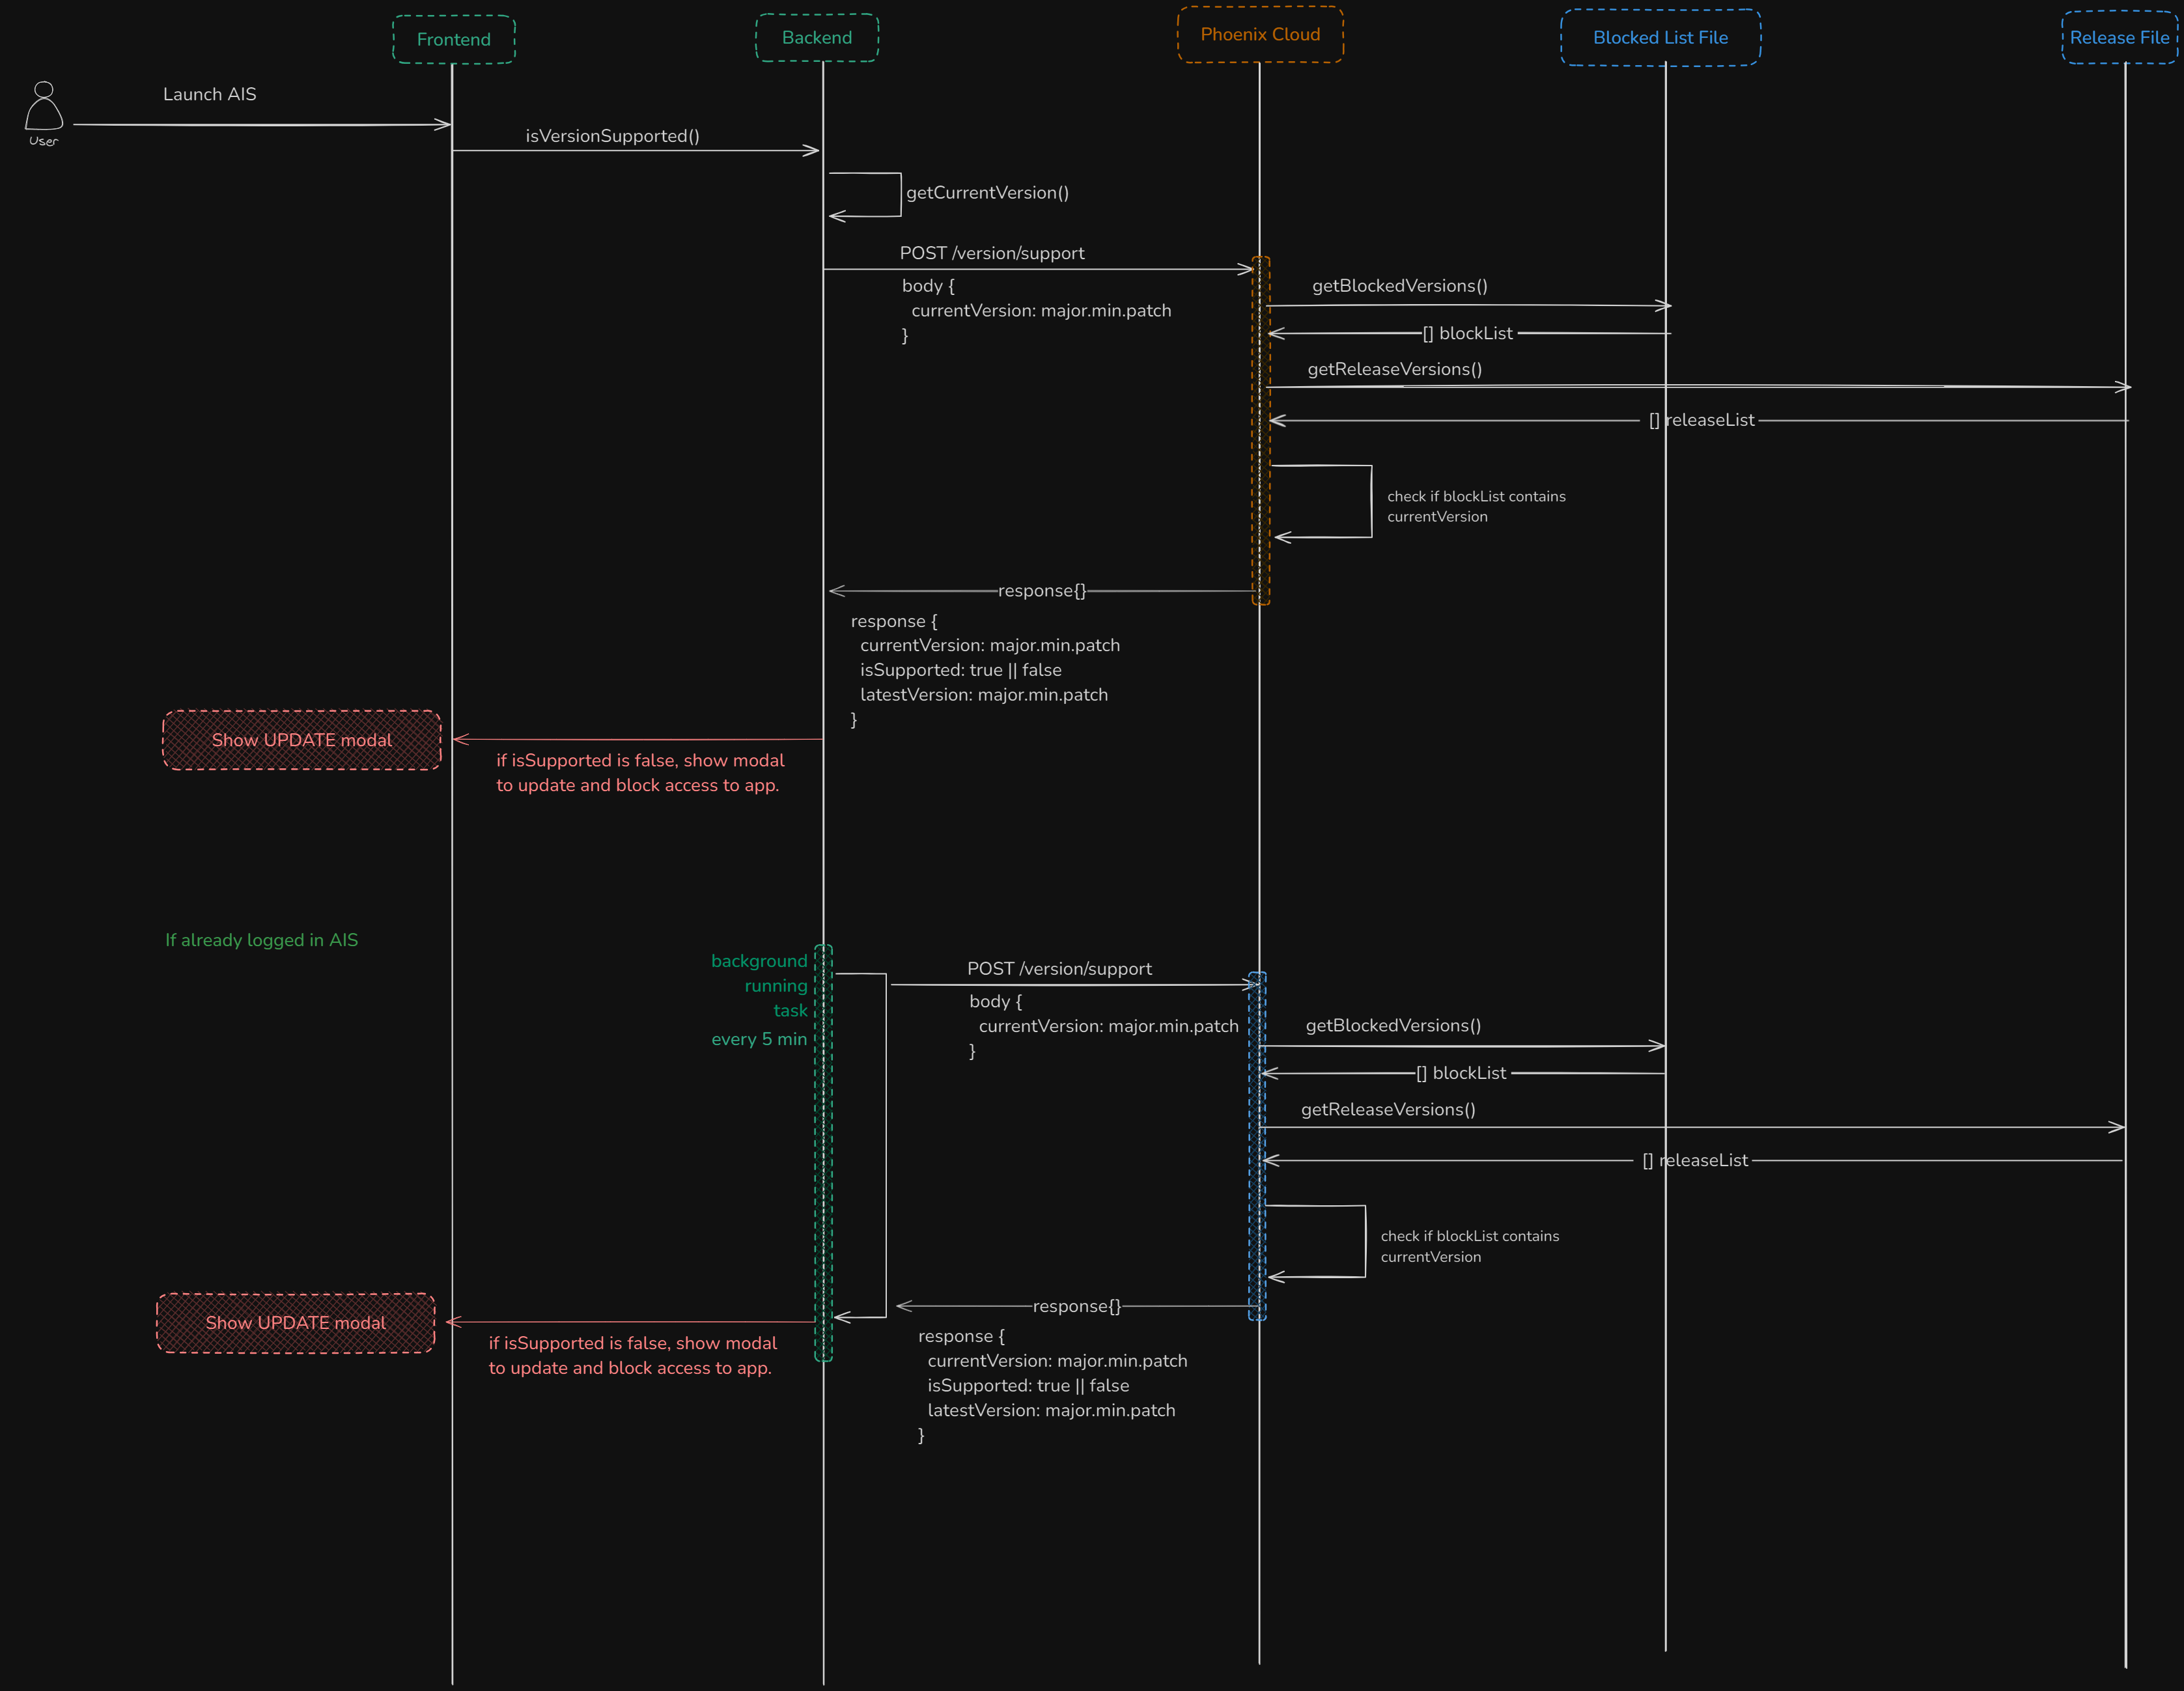

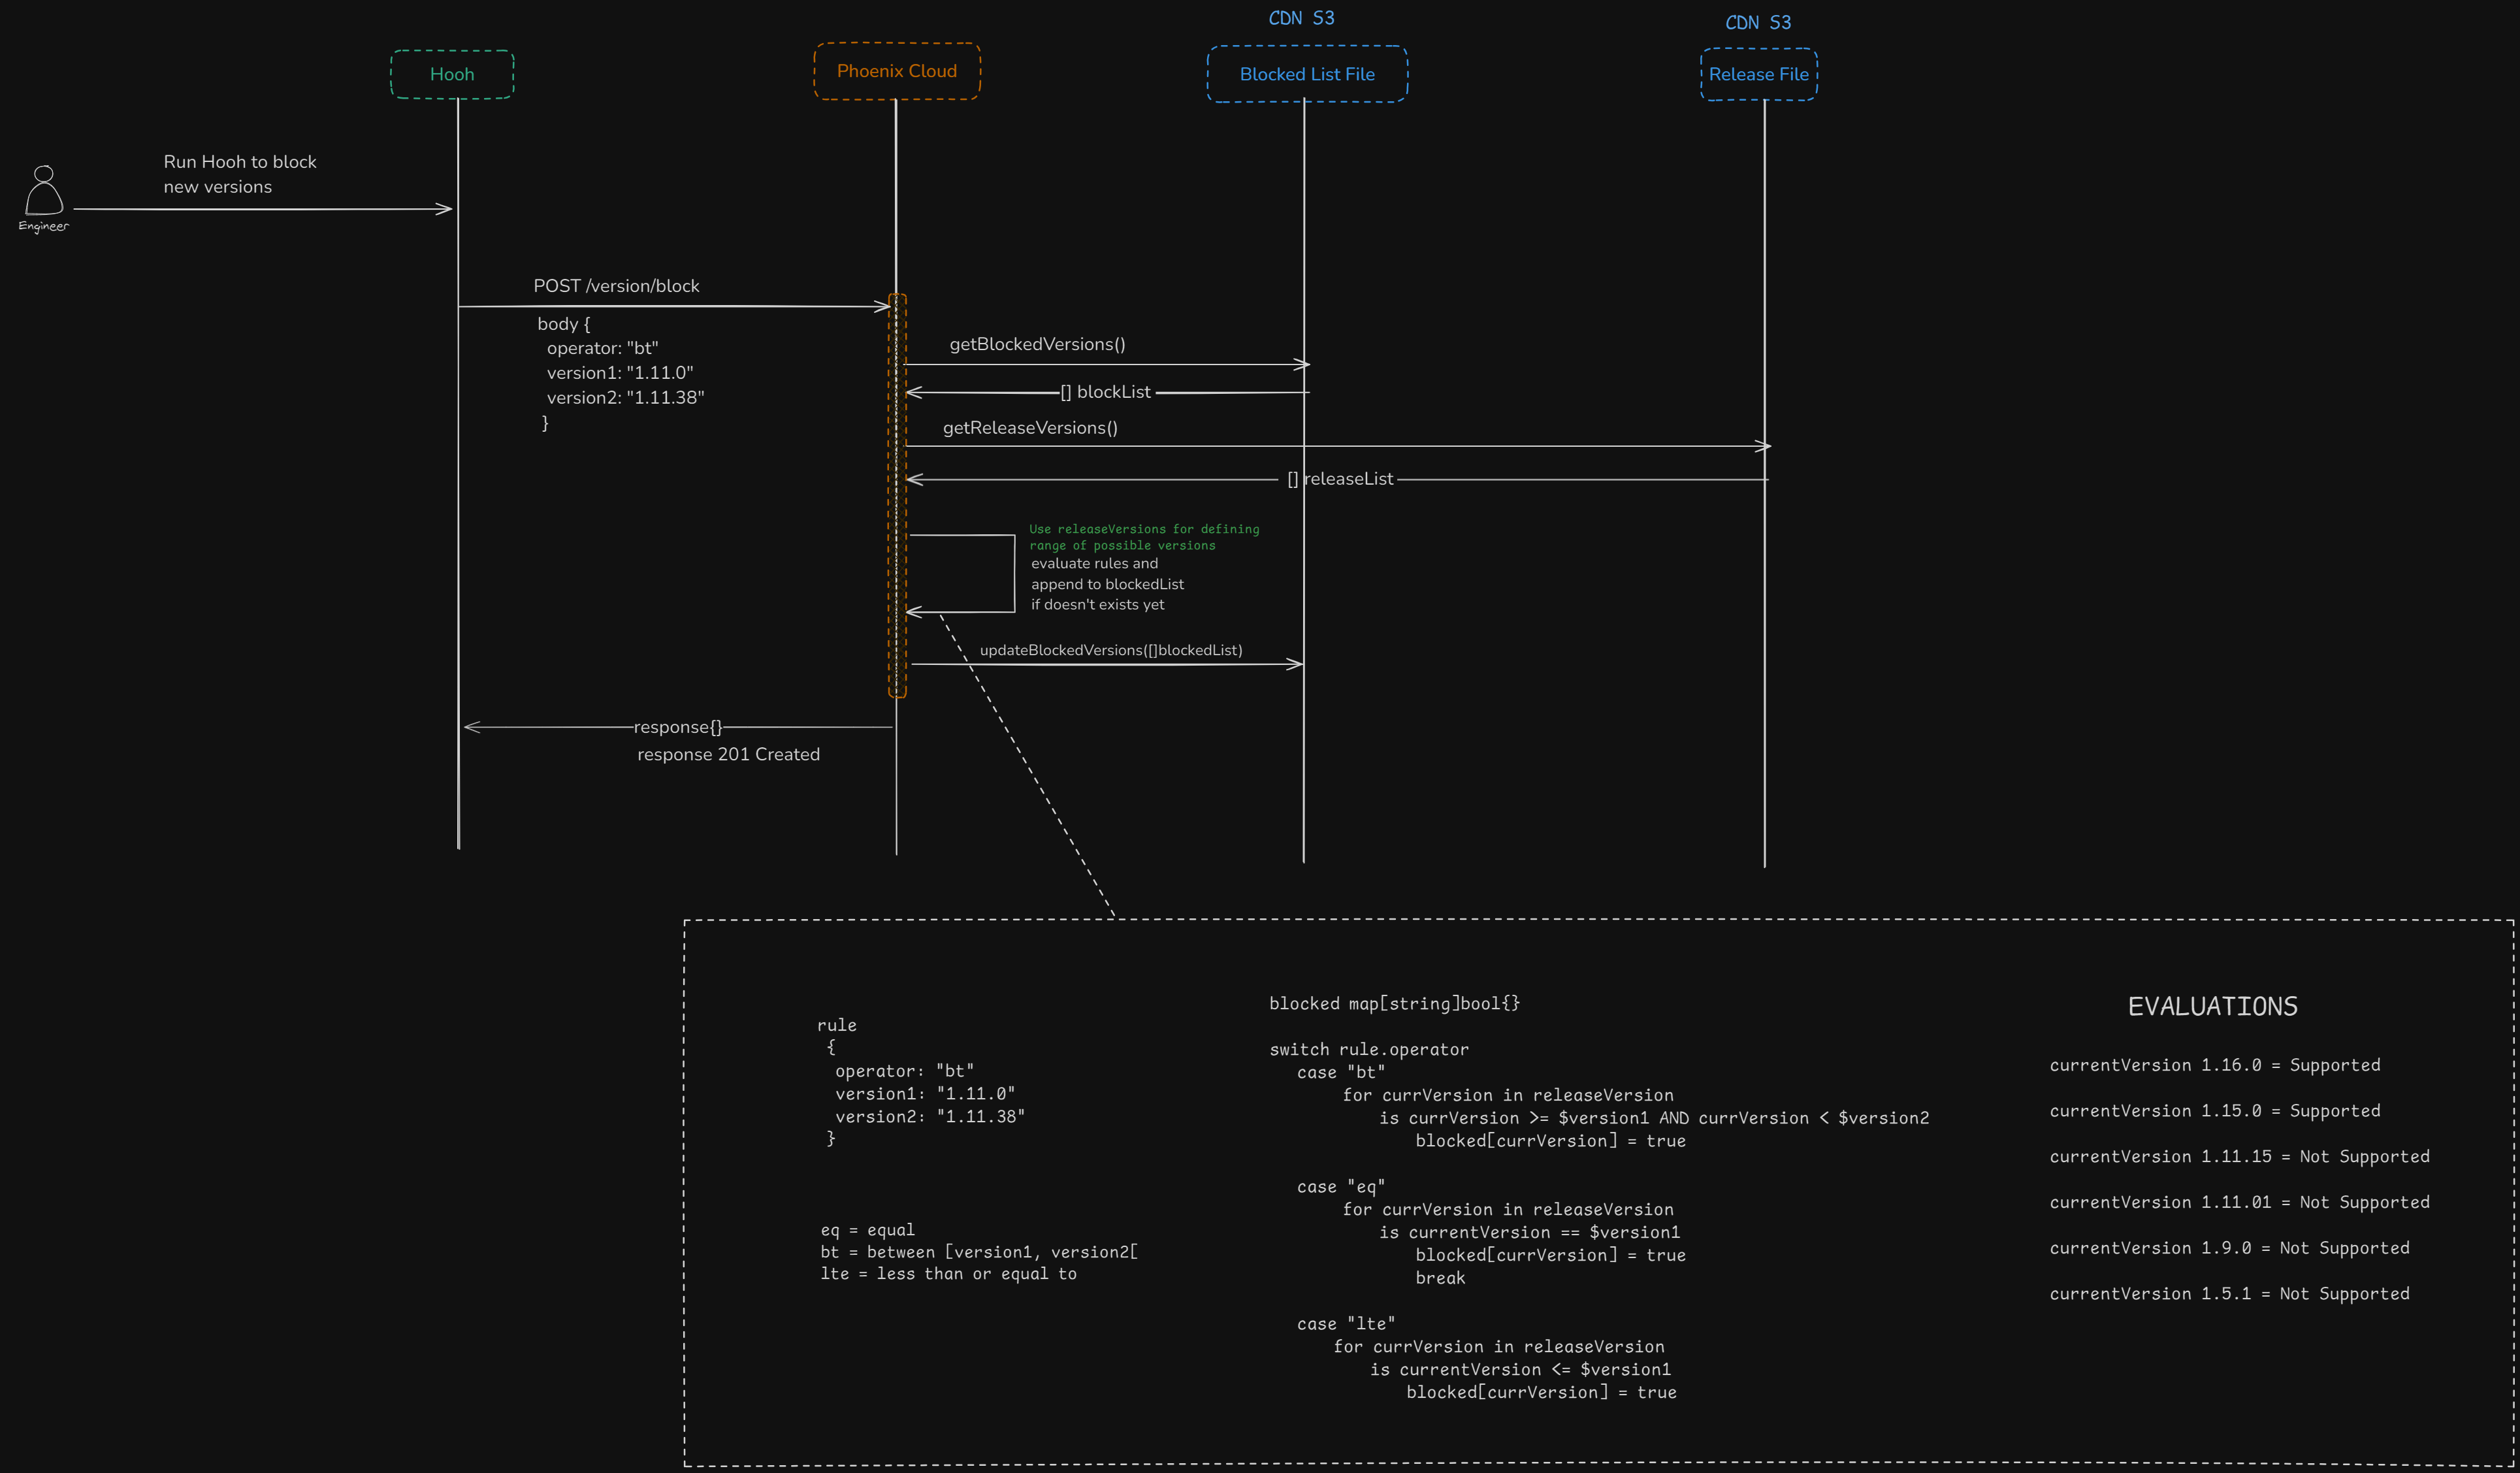

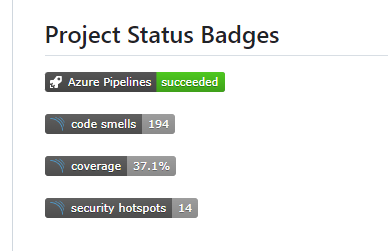

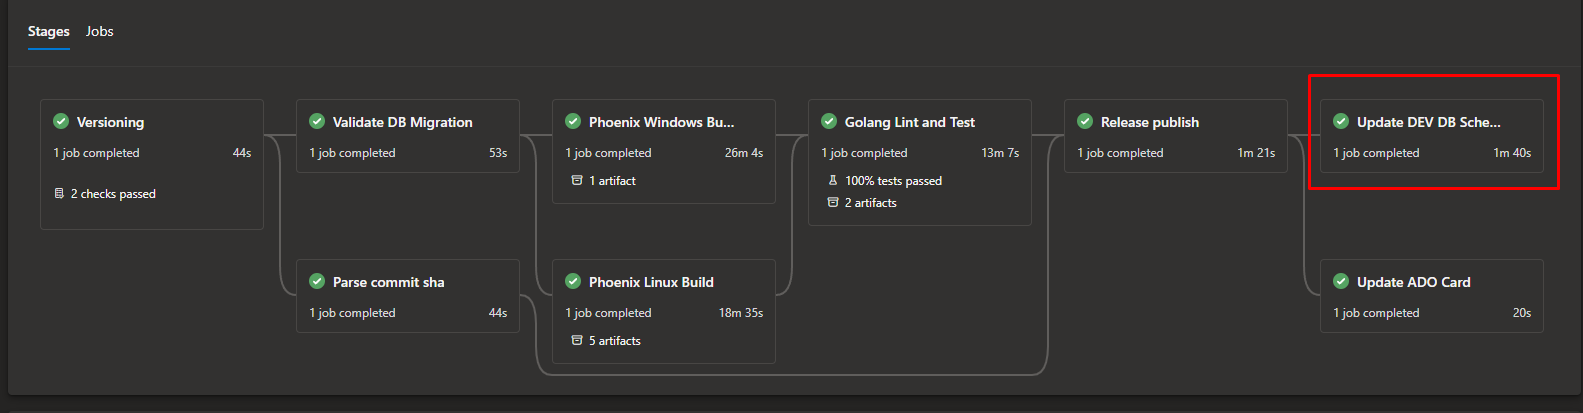

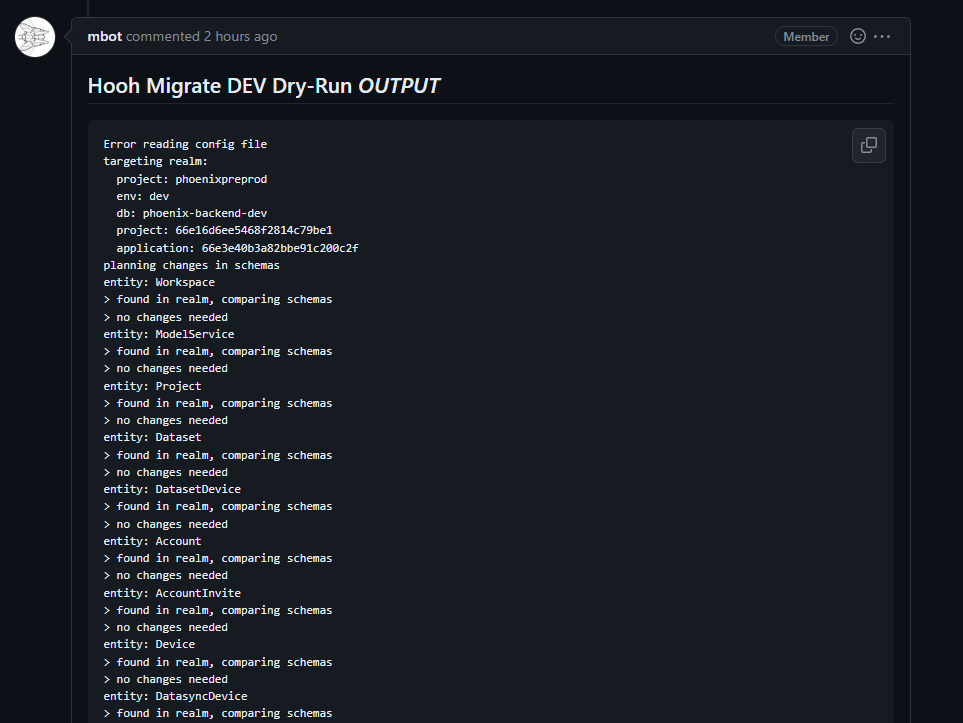

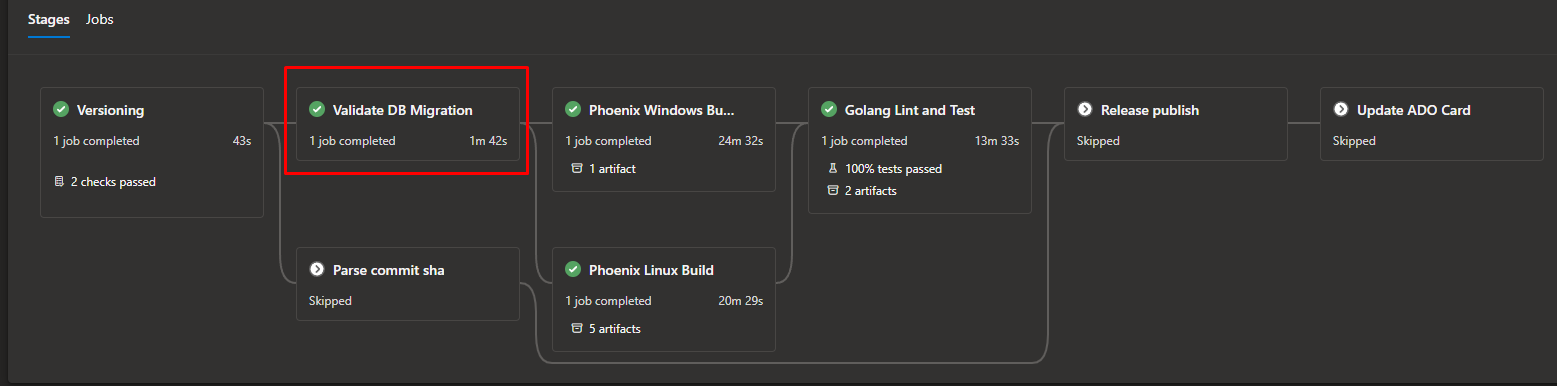

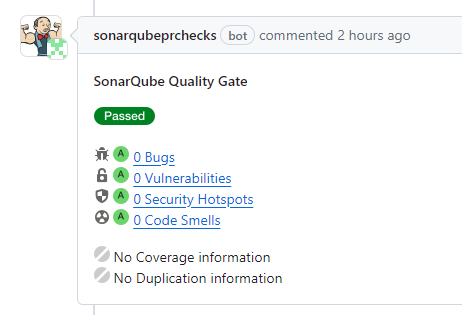

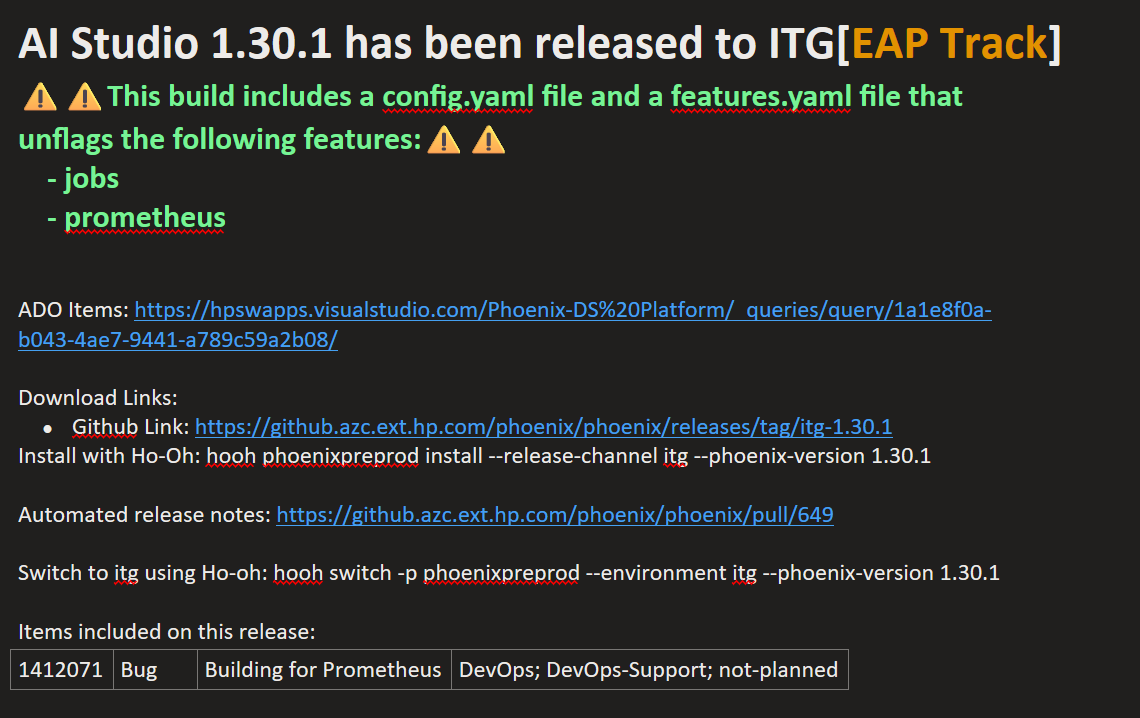

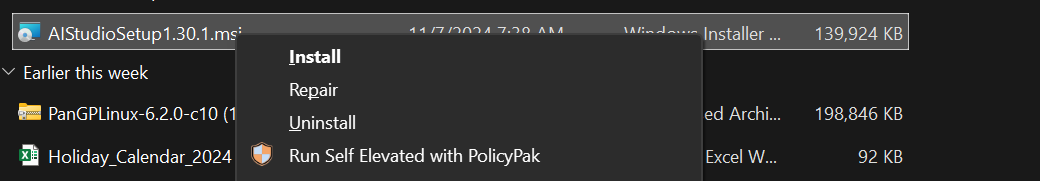

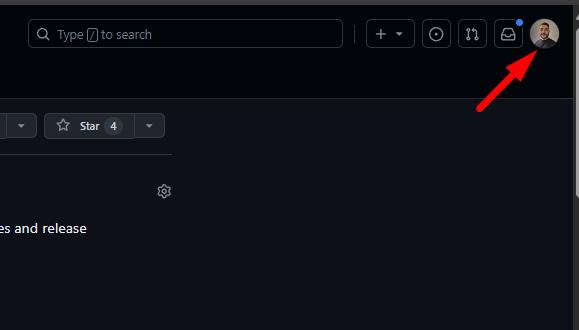

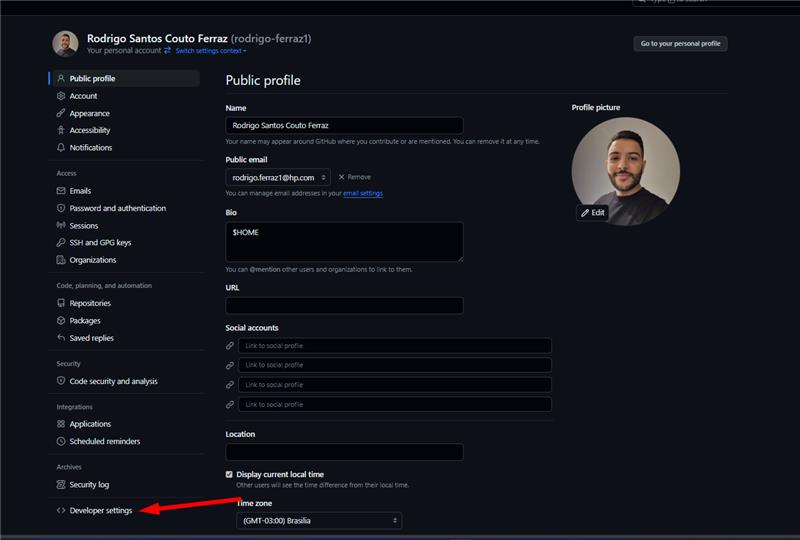

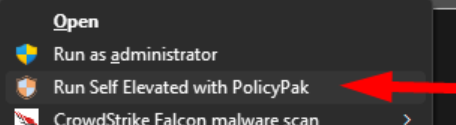

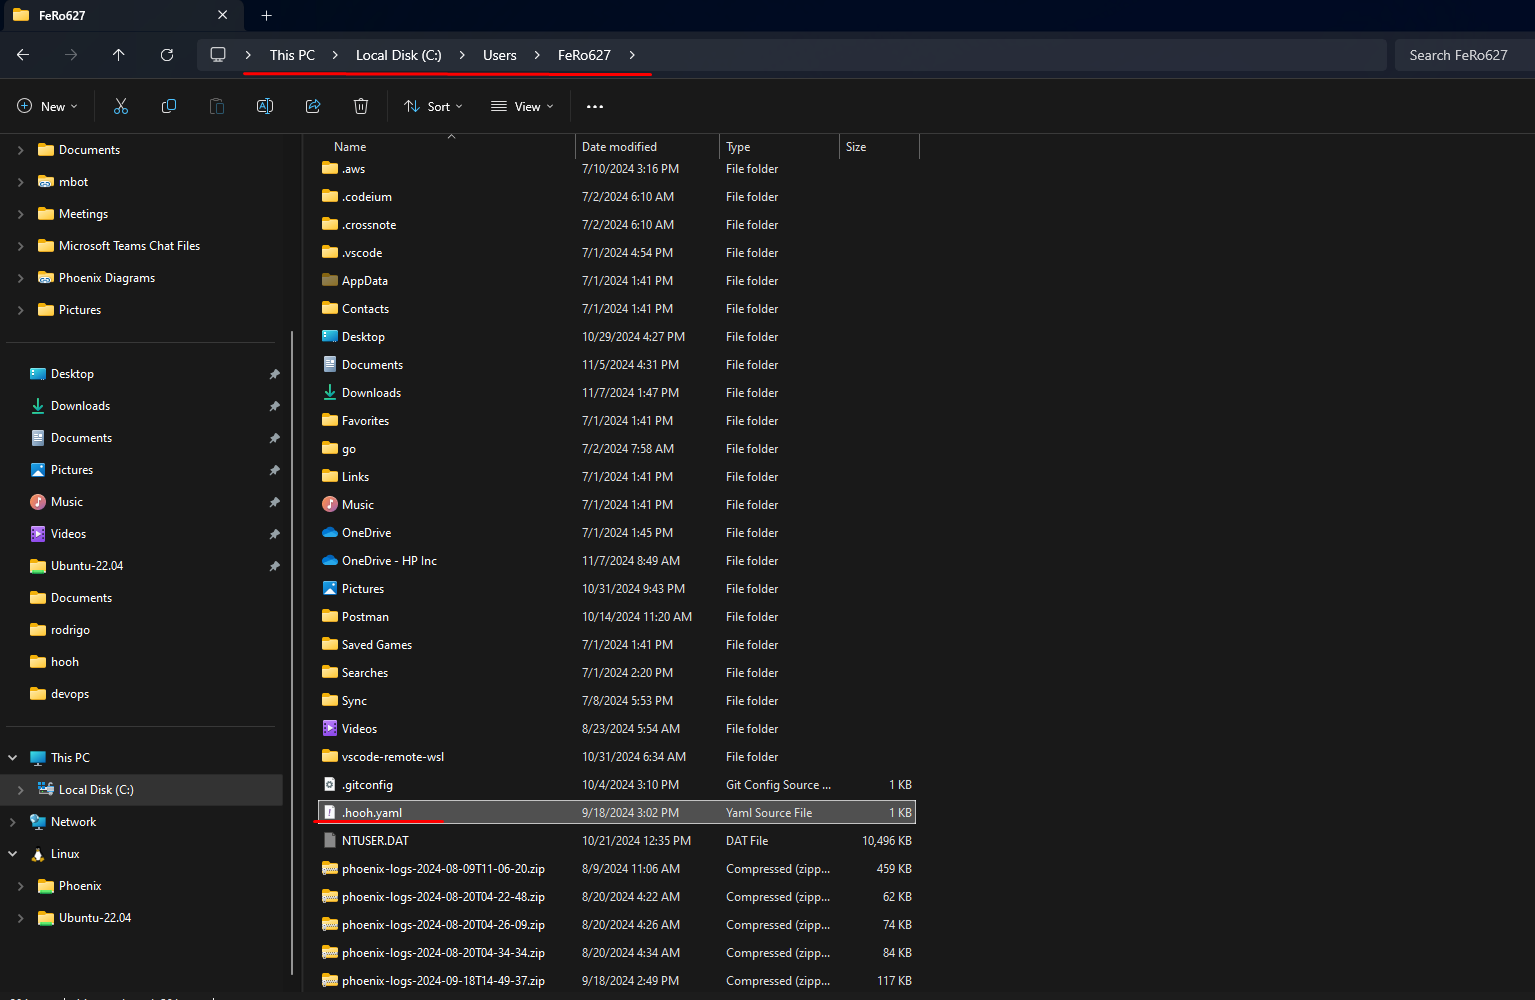

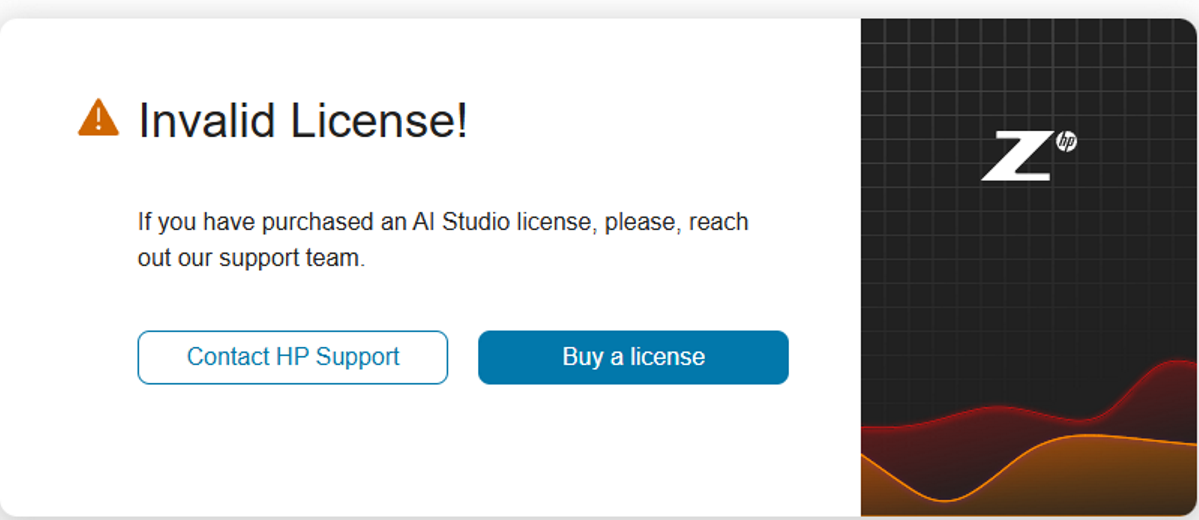

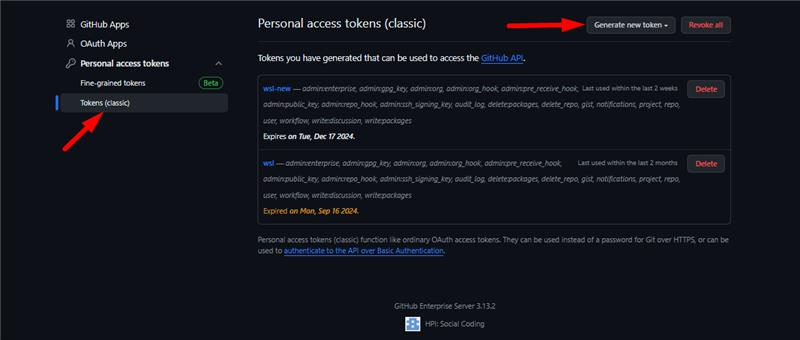

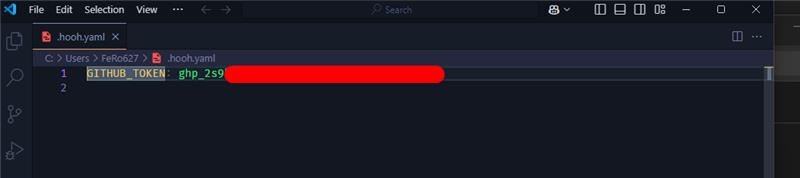

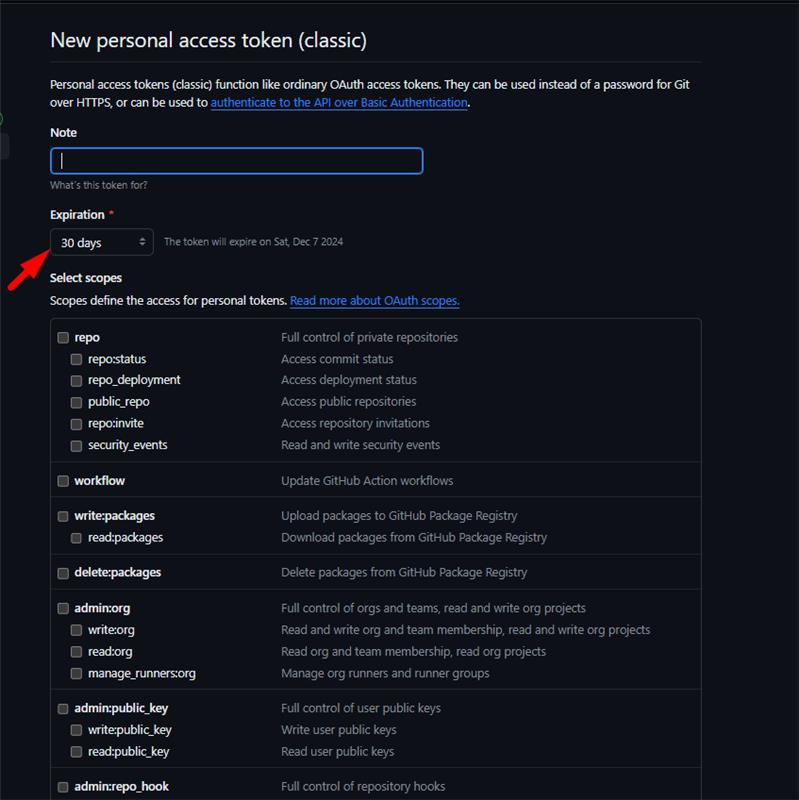

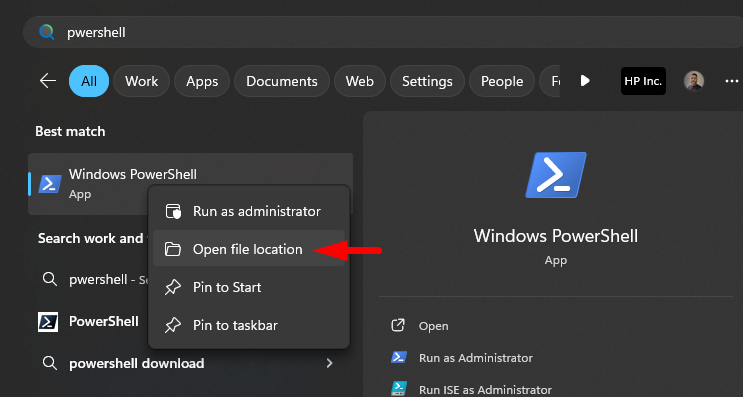

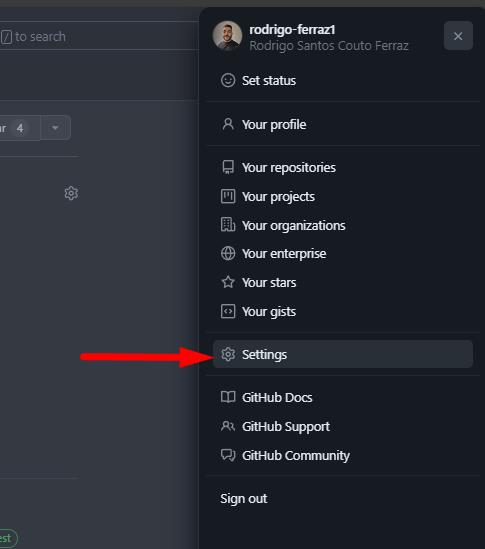

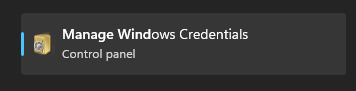

To manually clean your environment, follow these steps:

1. Backup important data: Before starting the cleanup process, make sure to back up all essential files and documents.

2. Identify unused software or plugins: Check for any outdated, unused, or redundant software programs and plugins. Uninstall them if they're not needed anymore.

3. Purge unnecessary system logs and cache files: Review your system's log files (e.g., /var/log) and clear out any obsolete entries that are no longer relevant to current system operations.

4. Remove temporary files and folders: Locate and delete all temporary files, folder structures, or caches created by various software applications during their runtime processes.

5. Update system packages and libraries: Ensure your operating system's package management tools (e.g., apt on Ubuntu) are up-to-date with the latest security patches and updates for any installed system packages or libraries.

6. Optimize resource usage settings: Go through all relevan

In [29]:
# ✅ Quick Test

question = "How do I manually clean my environment without hooh?"
print(mm_chain.invoke(question))


# MLFlow Model Service 

In this section, we demonstrate how to deploy a RAG-based chatbot service. This service provides a REST API endpoint that allows users to query the knowledge base with natural language questions, upload new documents to the knowledge base, and manage conversation history, all with built-in safeguards against sensitive information and toxicity. This service encapsulates all the functionality we developed in this notebook, including the document retrieval system, RAG-based question answering capabilities, and Galileo integration for protection, observation and evaluation. It demonstrates how to use our ChatbotService from the src/service directory. 

## Setup

In [ ]:
mlflow_evaluate_setup(
    secrets,
    mlflow_tracking_uri="/phoenix/mlflow"
)

# === Set MLflow experiment context ===
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

# === Validate local model file path ===
if not os.path.exists(LOCAL_MODEL_PATH):
    logger.info(f"⚠️ Warning: Model file not found at {LOCAL_MODEL_PATH}. Please verify the path.")

## Log & Register Model

In [ ]:
# === Log and register model to MLflow ===
with mlflow.start_run(run_name=MLFLOW_RUN_NAME) as run:
    
    # Log model artifacts using custom ChatbotService
    ChatbotService.log_model(
        artifact_path=MLFLOW_MODEL_NAME,
        config_path=CONFIG_PATH,
        secrets_path=SECRETS_PATH,
        docs_path=DATA_PATH,
        model_path=LOCAL_MODEL_PATH,
        demo_folder=DEMO_FOLDER
    )

    # Construct the URI for the logged model
    model_uri = f"runs:/{run.info.run_id}/{MLFLOW_MODEL_NAME}"

In [ ]:
# Register the model into MLflow Model Registry
mlflow.register_model(
    model_uri=model_uri,
    name=MLFLOW_MODEL_NAME
)

logger.info(f"✅ Model registered successfully with run ID: {run.info.run_id}")

## Evaluate Hallucination, Answer Relevance

In [ ]:
model_source = config["model_source"]

In [ ]:
%%time

llm = initialize_llm(model_source, secrets)

In [ ]:

def model(batch_df: pd.DataFrame) -> pd.DataFrame:
    preds, contexts = [], []
    for q in batch_df["questions"]:
        answer = mm_chain.invoke(q)
        preds.append(answer)

        docs = retriever.get_relevant_documents(q)
        contexts.append(" ".join(d.page_content for d in docs))

    # keep the incoming index so every batch’s rows stay unique
    return pd.DataFrame(
        {
            "result": preds,
            "source_documents": contexts,
        },
        index=batch_df.index,      #  ← key line
    )

# --- 3)  Evaluation dataset
eval_df = pd.DataFrame({"questions": [
    "What naming convention should I use for a new blueprint project folder?",
    "What is the first step in the standard blueprint testing workflow?",
    "How do I fetch logs from a running Kubernetes pod?",
]})

judge = LocalGenAIJudge(
    llm=llm
)

faithfulness_metric = judge.to_mlflow_metric("faithfulness")
relevance_metric = judge.to_mlflow_metric("relevance")

results = mlflow.evaluate(
    model,
    eval_df,
    predictions="result",
    evaluators="default",
    extra_metrics=[faithfulness_metric, relevance_metric],
    evaluator_config={
        "col_mapping": {
            "inputs": "questions",
            "context": "source_documents"
        }
    },
)


Built with ❤️ using Z by HP AI Studio.